# Using ALBERT for Question Answering - SQuAD

Updates:

Things implemented:
- Data Loading
- Model
- Learner
- Prediction on new data
- Optimizer selection
- Segment IDs
- F1 Score
- Checkpoints
- Use a more powerful machine to train
- Gradient Accumulation
- Squad 2.0
    - Multi Task Learning Changes

TODO:
- Consider using the sliding window approach for long sequences


In [1]:
from src import *
from transformers import AutoTokenizer, AlbertModel,AlbertPreTrainedModel
from pathlib import Path
import numpy as np
import pandas as pd
import json
import pickle
import re
import collections
from tqdm import tqdm, trange
from datetime import datetime
import logging

In [2]:
# logging.basicConfig()
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

In [3]:
config = Config(
    data_path = Path("../data/SQuAD/2.0"), # replace with the directory containing the parsed csv files
    output_dir = Path("./checkpoints"), # for storing model weights between epochs
    task = "SQuAD",
    squad_version = "2.0",
    testing=True,
    seed = 2020,
    model = 'albert-base-v2',
    max_lr=5e-5,
    optimizer="lamb", # choose between 'adam' or 'lamb'
    epochs=2,
    use_fp16=False,
    recreate_ds=False,
    bs=4, 
    effective_bs=4, # set this different from bs to determine gradient accumulation steps (i.e. effective_bs/bs)
    max_seq_len=512,
    start_tok = "[CLS]",
    end_tok = "[SEP]",
    sep_tok = "[SEP]",
    unk_tok_idx=1,
    sep_idx=3,
    pad_idx=0,
    feat_cols = ["question","paragraph"],
    label_cols = ["idxs","is_impossible"],
    adjustment = 2,
    save_checkpoint = True,
    load_checkpoint=None#"albert-base-v2-accuracy-0.72-epoch-0-2020-01-24 18:54:15.308899"
)

config.model_name = re.findall(r"(.+?)-",config.model)[0]

# set optimizer
assert config.optimizer.lower() in ["adam","lamb"], f"invalid optimizer in config {config.optimizer}"
config.opt_func = lamb_opt() if config.optimizer.lower() == "lamb" else adam_opt()

In [4]:
# utility functions
def remove_max_sl(df):
    init_len = len(df)
    df = df[df.seq_len < config.max_seq_len-2]
    new_len = len(df)
    print(f"dropping {init_len - new_len} out of {init_len} questions")
    return df

def str2tensor(s):
    indices = re.findall("\d+",s)
    return torch.tensor([int(indices[0]), int(indices[1])], dtype=torch.long)

# Loading the data

In [5]:
train = pd.read_csv(config.data_path/f"train_{config.squad_version}_{config.model_name}.csv")
valid = pd.read_csv(config.data_path/f"val_{config.squad_version}_{config.model_name}.csv")

In [6]:
# randomizing the order of training data
train = train.sample(frac=1,random_state = config.seed).reset_index(drop=True)
valid = valid.sample(frac=1, random_state = config.seed).reset_index(drop=True)

In [7]:
# reduce df sizes if testing
if config.testing:
    train = train[:1000]
    valid = valid[:500]

In [8]:
train, valid = remove_max_sl(train), remove_max_sl(valid)

dropping 1 out of 1000 questions
dropping 3 out of 500 questions


In [9]:
train.head()

,question,paragraph,answer,idxs,seq_len,is_impossible
0,What is the mean yearly temperature in Hyderab...,Hyderabad has a tropical wet and dry climate (...,"['▁26', '.', '6', '▁', '°', 'c']","[46, 52]",214,False
1,What happens after a bill is delivered to the ...,After the President signs a bill into law (or ...,"['▁assigned', '▁a', '▁law', '▁number']","[62, 66]",151,False
2,What notable piece of legislation did Michael ...,"In 1945, Plymouth-born Michael Foot was electe...","['▁1974', '▁health', '▁and', '▁safety', '▁at',...","[47, 54]",70,False
3,How does the Seattle ferry line compare to the...,King County Metro provides frequent stop bus s...,"['▁third', '▁largest']","[146, 148]",177,False
4,What team did Arsenal defeat at Wembley in 2015?,Arsenal reached the final of the 2007 and 2011...,['▁chelsea'],"[177, 178]",198,False


# Setting up the Tokenizer

In [10]:
class TokenizerProcessor(Processor):
    def __init__(self, tok_func, max_sl, start_tok, end_tok, pre_rules=None,post_rules=None):
        self.tok_func,self.max_sl = tok_func,max_sl
        self.pre_rules,self.post_rules=pre_rules,post_rules
        self.start_tok, self.end_tok = start_tok, end_tok

    def proc1(self, x): return [self.start_tok] + self.tok_func(x)[:self.max_sl-2] + [self.end_tok]
    
    def __call__(self, items): return tqdm([self.proc1(x) for x in items])

class NumericalizeProcessor(Processor):
    """
    only works with an existing vocab at the moment and min_freq is not accounted for
    """
    def __init__(self, vocab:dict, unk_tok_idx:int, min_freq=2): 
        self.vocab, self.unk_tok_idx, self.min_freq = vocab, unk_tok_idx, min_freq
    
    def proc1(self, x): return [self.vocab[i] if i in self.vocab else self.unk_tok_idx for i in x]
    
    def __call__(self, items): 
        if getattr(self, 'otoi', None) is None:
            self.otoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.vocab)})
        return tqdm([self.proc1(x) for x in items])

In [11]:
tok = AutoTokenizer.from_pretrained(config.model)
proc_tok = TokenizerProcessor(tok.tokenize, config.max_seq_len, config.start_tok, config.end_tok)

In [12]:
vocab = {tok.convert_ids_to_tokens(i):i for i in range(tok.vocab_size)}
proc_num = NumericalizeProcessor(vocab, unk_tok_idx=config.unk_tok_idx)

In [13]:
class QALabelProcessor(Processor):
    def __init__(self, parse_func = noop, adjustment = 2):
        self.parse_func = parse_func
        self.adjustment = adjustment
        self.vocab=None
        
    def cat_proc1(self,item): return self.otoi[item]
    def index_proc1(self, item): return self.parse_func(item) + self.adjustment
    
    def __call__(self, items): 
        if self.vocab is None:
            self.vocab = uniqueify([o[1] for o in items])
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [(self.index_proc1(item[0]),self.cat_proc1(item[1])) for item in items] # we want the 
    

In [14]:
proc_qa = QALabelProcessor(str2tensor,config.adjustment)

In [15]:
class SquadTextList(ItemList):      
    @classmethod  
    def from_df(cls, df, feat_cols, label_cols, sep_tok, test=False):
        feat_cols = listify(feat_cols)
        x = df[feat_cols[0]]
        for i in range(1,len(feat_cols)):
            x += f" {sep_tok} " + df[feat_cols[i]]
        labels = cls(df[label_cols].values) if not test else cls([[None,None] for _ in len(df)])
        return cls(x,labels=labels)

In [16]:
if (not (config.data_path/f"squad_{config.squad_version}_data_trn.pkl").exists()) or config.recreate_ds or config.testing:
    il_train = SquadTextList.from_df(train,config.feat_cols,config.label_cols,config.sep_tok)
    il_valid = SquadTextList.from_df(valid,config.feat_cols,config.label_cols,config.sep_tok)

    ll_valid = LabeledData(il_valid,il_valid.labels,proc_x = [proc_tok,proc_num], proc_y=[proc_qa])
    ll_train = LabeledData(il_train,il_train.labels,proc_x = [proc_tok,proc_num], proc_y=[proc_qa])

    # saving/loading presaved data if not testing
    if not config.testing:
        # save an object
        pickle.dump(ll_train, open( config.data_path/f"squad_{config.squad_version}_data_trn.pkl", "wb" ) )
        pickle.dump(ll_valid, open( config.data_path/f"squad_{config.squad_version}_data_val.pkl", "wb" ) )
else:
    # load an object
    ll_train = pickle.load( open( config.data_path/f"squad_{config.squad_version}_data_trn.pkl", "rb" ) )
    ll_valid = pickle.load( open( config.data_path/f"squad_{config.squad_version}_data_val.pkl", "rb" ) )

100%|██████████| 999/999 [00:00<00:00, 332205.64it/s]


In [17]:
from torch.utils.data import Sampler

class SortSampler(Sampler):
    def __init__(self, data_source, key): self.data_source,self.key = data_source,key
    def __len__(self): return len(self.data_source)
    def __iter__(self):
        return iter(sorted(list(range(len(self.data_source))), key=self.key, reverse=True))

In [18]:
class SortishSampler(Sampler):
    def __init__(self, data_source, key, bs):
        self.data_source,self.key,self.bs = data_source,key,bs

    def __len__(self) -> int: return len(self.data_source)

    def __iter__(self):
        idxs = torch.randperm(len(self.data_source))
        megabatches = [idxs[i:i+self.bs*50] for i in range(0, len(idxs), self.bs*50)]
        sorted_idx = torch.cat([tensor(sorted(s, key=self.key, reverse=True)) for s in megabatches])
        batches = [sorted_idx[i:i+self.bs] for i in range(0, len(sorted_idx), self.bs)]
        max_idx = torch.argmax(tensor([self.key(ck[0]) for ck in batches]))  # find the chunk with the largest key,
        batches[0],batches[max_idx] = batches[max_idx],batches[0]            # then make sure it goes first.
        batch_idxs = torch.randperm(len(batches)-2)
        sorted_idx = torch.cat([batches[i+1] for i in batch_idxs]) if len(batches) > 1 else LongTensor([])
        sorted_idx = torch.cat([batches[0], sorted_idx, batches[-1]])
        return iter(sorted_idx)

In [19]:
def pad_collate_qa(samples, pad_idx=config.pad_idx, pad_first=False):
    max_len = max([len(s[0]) for s in samples])
    res = torch.zeros(len(samples), max_len).long() + pad_idx
    for i,s in enumerate(samples):
        if pad_first: res[i, -len(s[0]):] = torch.LongTensor(s[0])
        else:         res[i, :len(s[0]) ] = torch.LongTensor(s[0])
    qa_idxs = torch.cat([s[1][0].unsqueeze(0) for s in samples])
    imp_labels = torch.tensor([s[1][1] for s in samples])
    return res, (qa_idxs, imp_labels)

In [20]:
train_sampler = SortishSampler(ll_train.x, key=lambda t: len(ll_train[int(t)][0]), bs=config.bs)
train_dl = DataLoader(ll_train, batch_size=config.bs, sampler=train_sampler, collate_fn=pad_collate_qa)

valid_sampler = SortSampler(ll_valid.x, key=lambda t: len(ll_valid[int(t)][0]))
valid_dl = DataLoader(ll_valid, batch_size=config.bs, sampler=valid_sampler, collate_fn=pad_collate_qa)

In [21]:
x,y = next(iter(train_dl))

# Setting up the Databunch

In [22]:
data = DataBunch(train_dl,valid_dl)

# Training Model

In [23]:
def set_segments(x,sep_idx=config.sep_idx):
    res = x.new_zeros(x.size())
    for row_idx, row in enumerate(x):
        in_seg_1 = False
        for val_idx,val in enumerate(row):
            if val == sep_idx:
                in_seg_1 = True
            if in_seg_1: 
                res[row_idx,val_idx] = 1
    return res

In [24]:
weights = config.output_dir/config.load_checkpoint if config.load_checkpoint else config.model

In [25]:
class AlbertForQuestionAnsweringMTL(AlbertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = AlbertModel(config)
        self.qa_outputs = nn.Linear(config.hidden_size, config.num_labels)
        self.imp_outputs = nn.Linear(config.hidden_size, 2)
        self.init_weights()

    def forward(self, input_ids=None, token_type_ids=None, position_ids=None):

        outputs = self.bert(input_ids=input_ids, token_type_ids=token_type_ids, position_ids=position_ids)

        sequence_output, pooled_output = outputs

        logits_qa = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits_qa.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
    
        imp_logits = self.imp_outputs(pooled_output)

        outputs = (start_logits, end_logits, imp_logits,) + outputs[2:]
        return outputs  # start_logits, end_logits, (hidden_states), (attentions)

In [26]:
def save_model(learner,output_dir: Path):
    def _create_dir(dirc):
        if not os.path.exists(dirc): os.mkdir(dirc)
    epoch = learner.epoch
    metric = round(float(learner.qa_avg_stats.valid_stats.avg_stats[1]),2)
    _create_dir(output_dir)
    model_dir = f"{config.model}-accuracy-{metric}-epoch-{epoch}-" + str(datetime.now())
    _create_dir(output_dir/model_dir)
    learner.model.save_pretrained(output_dir/model_dir) # learner.model.bert.save...

class SaveModelCallback(Callback):
    def __init__(self,save_model_func,output_dir):
        self.output_dir, self.save_model_func = output_dir,save_model_func
    def after_epoch(self):
        self.save_model_func(self, self.output_dir)        

In [27]:
class CudaCallbackMTL(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = \
        self.xb.cuda(), (self.run.yb[0].cuda(), self.run.yb[1].cuda())
        
        

In [28]:
# gradient accumulation
class GradientAccumulation(Callback):
    def __init__(self,bs,effective_bs):
        self.bs, self.effective_bs = bs, effective_bs
    def after_backward(self):
        if self.n_iter*self.bs % self.effective_bs != 0: raise CancelBatchException()

In [29]:
y[1]

tensor([1, 0, 0, 1])

In [30]:
# defining the loss function
def cross_entropy_qa_mtl(input, target):
    """
    Summing the cross entropy loss from the starting and ending indices. 
    """
    qa_loss = torch.add(F.cross_entropy(input[0], target[0][:,0]) , F.cross_entropy(input[1], target[0][:,1]))
    imp_loss = F.cross_entropy(input[2], target[1])
    loss = qa_loss + imp_loss
    return loss

In [31]:
class QAAvgStats(AvgStats):
    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb, run.xb) * bn
            
class QAAvgStatsCallback(AvgStatsCallback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = QAAvgStats(metrics,True),QAAvgStats(metrics,False)

In [32]:
# defining the evaluation metrics based on squad evaluation method
def acc_qa(input,target,xb):
    """
    Taking the average between the accuracies of predicting the start and ending indices
    """
    return (accuracy(input[0], target[0][:,0]) + accuracy(input[1], target[0][:,1]))

def acc_imp(input,target,xb):
    return accuracy(input[2], target[1])

def exact_match(input,target,xb):
    def _acc(out, yb): return (torch.argmax(out, dim=1)==yb).float()
    return (_acc(input[0], target[0][:,0]) + _acc(input[1], target[0][:,1]) == 2).float().mean()

In [33]:
def f1_score(input,target,xb):
    """
    based on the official evaluation script:
    https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/
    """
    pred_starts,pred_ends = [torch.argmax(out, dim=1) for out in input]
    gold_starts,gold_ends = target[:,0], target[:,1]
    
    def _get_toks(idx,start,end):
        if start == end: end += 1
        return xb[idx][start:end]
    
    def _score1(pred_toks,gold_toks):
        common = collections.Counter(gold_toks.tolist()) & collections.Counter(pred_toks.tolist())
        num_same = sum(common.values())
        if num_same == 0: 
            return 0
        precision = 1.0 * num_same / len(pred_toks)
        recall = 1.0 * num_same / len(gold_toks)
        f1 = (2 * precision * recall) / (precision + recall)
        return f1
    
    pred_toks = [_get_toks(i,start,end) for i,(start,end) in enumerate(zip(pred_starts,pred_ends))]
    gold_toks = [_get_toks(i,start,end) for i,(start,end) in enumerate(zip(gold_starts,gold_ends))]
    score = np.mean([_score1(pred,gold) for pred,gold in zip(pred_toks,gold_toks)])
    return score             

In [56]:
cbfs = [partial(QAAvgStatsCallback,[acc_qa,exact_match,acc_imp]), # f1_score
        CudaCallbackMTL,
        ProgressCallback,
        Recorder]

if not config.testing and config.save_checkpoint: 
    cbfs.append(partial(SaveModelCallback,save_model,config.output_dir))
    
if config.effective_bs and config.bs != config.effective_bs:
    cbfs.append(partial(GradientAccumulation,config.bs,config.effective_bs))

In [35]:
model = AlbertForQuestionAnsweringMTL.from_pretrained(weights)

In [51]:
def albert_splitter(m, g1=[],g2=[]):
    l = list(dict(m.named_children()).keys())
    if "qa_outputs" in  l: g2+= m.qa_outputs.parameters()
    if "imp_outputs" in l: g2+= m.imp_outputs.parameters()
    if isinstance(m,torch.nn.modules.normalization.LayerNorm):
        g2+= m.parameters()
    elif hasattr(m, 'weight'): 
        g1+= m.parameters()
    for ll in m.children(): albert_splitter(ll, g1, g2)
    return g1,g2



In [52]:
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/11_train_imagenette.ipynb
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

# https://github.com/fastai/course-v3/blob/master/nbs/dl2/11a_transfer_learning.ipynb
def sched_1cycle(lrs, pct_start=0.3, mom_start=0.95, mom_mid=0.85, mom_end=0.95):
    phases = create_phases(pct_start)
    sched_lr  = [combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
                 for lr in lrs]
    sched_mom = combine_scheds(phases, cos_1cycle_anneal(mom_start, mom_mid, mom_end))
    return [ParamScheduler('lr', sched_lr),
            ParamScheduler('mom', sched_mom)]

disc_lr_sched = sched_1cycle([config.max_lr,1e-4], 0.3) # 3e-2 best with adam, 1e-3 for lamb

In [53]:
# the learning rate we apply here does not matter since we are scheduling 
learn = Learner(model, data, cross_entropy_qa_mtl,lr=config.max_lr,cb_funcs=cbfs,splitter=albert_splitter,opt_func=config.opt_func)


In [55]:
learn.fit(2,cbs=disc_lr_sched)

epoch,train_loss,train_acc_qa,train_exact_match,valid_loss,valid_acc_qa,valid_exact_match,time
0,10.179211,0.059059,0.001001,10.313427,0.056338,0.000000,01:09
1,10.071210,0.070070,0.002002,10.269855,0.050302,0.000000,01:09
2,9.881288,0.082082,0.005005,10.266192,0.056338,0.000000,01:09
3,9.578624,0.107107,0.005005,10.264467,0.064386,0.000000,01:10
4,9.200674,0.144144,0.007007,10.370122,0.072435,0.000000,01:10
5,8.811831,0.189189,0.010010,10.482208,0.054326,0.000000,01:10
6,8.417463,0.258258,0.024024,10.563443,0.050302,0.000000,01:10
7,8.045220,0.294294,0.028028,10.633261,0.056338,0.002012,01:10
8,7.759793,0.366366,0.035035,10.712132,0.052314,0.000000,01:10
9,7.603522,0.399399,0.042042,10.716063,0.052314,0.000000,01:10


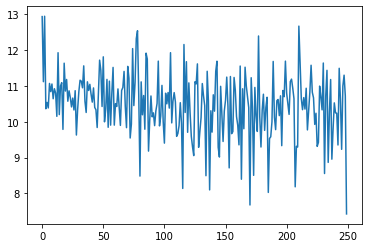

In [41]:
learn.recorder.plot_loss()

In [42]:
# manually save and load model weights

# save_model(learn,config.out_path)
# learn.model.bert.from_pretrained(config.output_dir/'albert-base-v2-accuracy-0.72-epoch-3-2020-01-24 16:22:37.693825')

# Predictions

In [43]:
def pad_collate_x(samples, pad_idx=config.pad_idx, pad_first=False):
    max_len = max([len(s[0]) for s in samples])
    res = torch.zeros(len(samples), max_len).long() + pad_idx
    for i,s in enumerate(samples):
        if pad_first: res[i, -len(s[0]):] = torch.LongTensor(s[0])
        else:         res[i, :len(s[0]) ] = torch.LongTensor(s[0])
    return res

In [44]:
# tests with samples 
sample1 = "[CLS] there have been thirty earthquakes in the past three days. [SEP] how many earthquakes have there been? [SEP]"
sample2 = "[CLS] the storm took place yesterday from dawn to dusk [SEP] what took place??"
sample3 = "[CLS] No.2 pencils are used a lot in schools. [SEP] what are used?"
# get_pred([sample1,sample2,sample3], learn.model, tok)

ValueError: too many values to unpack (expected 2)